In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Content of Table

# Import & transform data

## Import data

In [3]:
DATA_DIR = Path('data/single_request')
LATENCY_CSV = 'single_request_latency.csv'
SERVER_USAGE_CSV = 'single_request_server_usage.csv'
CLIENT_USAGE_CSV = 'single_request_client_usage.csv'

In [4]:
df_latency = pd.read_csv(DATA_DIR / LATENCY_CSV)
df_server_usage = pd.read_csv(DATA_DIR / SERVER_USAGE_CSV)
df_client_usage = pd.read_csv(DATA_DIR / CLIENT_USAGE_CSV)

## Transform data

In [5]:
df_latency = df_latency.rename(columns={'mode': 'protocol'})

### Standardise timestamps

Offset timestamps to a common baseline, which is the server start time for each epoch

In [6]:
def offset_timestamp_to_base(df, ts_cols: str | list[str], base_col='perf_base_ns'):
    """
    Offsets ts_col by subtracting base_col so timestamps start at zero.
    """
    cols = [ts_cols] if isinstance(ts_cols, str) else ts_cols

    for col in cols:
        df[col] = df[col] - df[base_col]

offset_timestamp_to_base(df_latency, ['t0', 't_req', 't_res', 't_in', 't_out'])
offset_timestamp_to_base(df_server_usage, 'ts')
offset_timestamp_to_base(df_client_usage, 'ts')

### Calculate Duration

Caluclate duration for each specific phase

In [7]:
# 1. Client “setup” only: create req, headers/URL, channel, in‐memory object
df_latency['client_setup_ns'] = df_latency['t_req'] - df_latency['t0']

# 2. Uplink latency (client→server network + server receive/parse)
df_latency['uplink_latency_ns'] = df_latency['t_in']  - df_latency['t_req']

# 3. Pure server processing (handler logic + response serialisation)
df_latency['server_processing_ns'] = df_latency['t_out'] - df_latency['t_in']

# 4. Downlink latency (server→client network + client parse/deserialisation)
df_latency['downlink_latency_ns'] = df_latency['t_res'] - df_latency['t_out']

Calculate end-to-end duration

In [8]:
# 1. Client‐observed round‐trip (serialisation + network + server + deserialisation)
df_latency['round_trip_ns'] = df_latency['t_res'] - df_latency['t_req']

# 2. Total in‐app runtime (setup + round‐trip)
df_latency['total_runtime_ns'] = df_latency['t_res'] - df_latency['t0']

In [9]:
# 1. Client‐observed round‐trip (serialisation + network + server + deserialisation)
df_latency['round_trip_ns'] = df_latency['t_res'] - df_latency['t_req']

# 2. Total in‐app runtime (setup + round‐trip)
df_latency['total_runtime_ns'] = df_latency['t_res'] - df_latency['t0']

### Caulculate speed

In [10]:
df_latency['items_per_s_round_trip'] = (df_latency['size'] / df_latency['round_trip_ns']) * 1_000_000_000
df_latency['items_per_s_total_runtime'] = (df_latency['size'] / df_latency['total_runtime_ns']) * 1_000_000_000

In [11]:
df_latency

,protocol,size,req_id,t0,t_req,t_res,t_in,t_out,perf_base_ns,epoch_base_ns,req_size_bytes,res_size_bytes,client_setup_ns,uplink_latency_ns,server_processing_ns,downlink_latency_ns,round_trip_ns,total_runtime_ns,items_per_s_round_trip,items_per_s_total_runtime
0,grpc,1,d6fc5c563cada9bc,343614125,347422000,352247833,351662125,351862083,37801799555250,1747488516924895000,2,100,3807875,4240125,199958,385750,4825833,8633708,207.218111,115.825089
1,grpc,1,fdd5cc376181e068,482784791,485150916,487121333,486641250,486794041,37801799555250,1747488516924895000,2,100,2366125,1490334,152791,327292,1970417,4336542,507.506787,230.598481
2,grpc,1,5ab938f342d65c35,616468000,618739000,620799833,620324875,620460500,37801799555250,1747488516924895000,2,100,2271000,1585875,135625,339333,2060833,4331833,485.240677,230.849158
3,grpc,1,b80220b2b1266432,752450708,754810125,756896458,756282041,756555000,37801799555250,1747488516924895000,2,100,2359417,1471916,272959,341458,2086333,4445750,479.309870,224.933926
4,grpc,1,7c30bc491bcbff11,887355208,889608000,891538250,891064625,891176125,37801799555250,1747488516924895000,2,100,2252792,1456625,111500,362125,1930250,4183042,518.067608,239.060473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,rest_proto,1000000,653de53aaf1bbba7,151030605875,151030616792,152453561459,151036716709,152102129000,38592351476166,1747489307440166000,4,100000000,10917,6099917,1065412291,351432459,1422944667,1422955584,702768.015645,702762.623967
2096,rest_proto,1000000,243cc780ea1b4eaa,152624262375,152624273417,154011828417,152630537542,153698221334,38592351476166,1747489307440166000,4,100000000,11042,6264125,1067683792,313607083,1387555000,1387566042,720692.152743,720686.417605
2097,rest_proto,1000000,dd7a5949f379400a,154180865334,154180876292,155575398459,154186921375,155252935125,38592351476166,1747489307440166000,4,100000000,10958,6045083,1066013750,322463334,1394522167,1394533125,717091.505366,717085.870585
2098,rest_proto,1000000,de56e6a79a06bb23,155745997000,155746009375,157150140542,155752297750,156829557000,38592351476166,1747489307440166000,4,100000000,12375,6288375,1077259250,320583542,1404131167,1404143542,712184.177306,712177.900684


## Inspection

In [12]:
df_latency.head()

,protocol,size,req_id,t0,t_req,t_res,t_in,t_out,perf_base_ns,epoch_base_ns,req_size_bytes,res_size_bytes,client_setup_ns,uplink_latency_ns,server_processing_ns,downlink_latency_ns,round_trip_ns,total_runtime_ns,items_per_s_round_trip,items_per_s_total_runtime
0,grpc,1,d6fc5c563cada9bc,343614125,347422000,352247833,351662125,351862083,37801799555250,1747488516924895000,2,100,3807875,4240125,199958,385750,4825833,8633708,207.218111,115.825089
1,grpc,1,fdd5cc376181e068,482784791,485150916,487121333,486641250,486794041,37801799555250,1747488516924895000,2,100,2366125,1490334,152791,327292,1970417,4336542,507.506787,230.598481
2,grpc,1,5ab938f342d65c35,616468000,618739000,620799833,620324875,620460500,37801799555250,1747488516924895000,2,100,2271000,1585875,135625,339333,2060833,4331833,485.240677,230.849158
3,grpc,1,b80220b2b1266432,752450708,754810125,756896458,756282041,756555000,37801799555250,1747488516924895000,2,100,2359417,1471916,272959,341458,2086333,4445750,479.309870,224.933926
4,grpc,1,7c30bc491bcbff11,887355208,889608000,891538250,891064625,891176125,37801799555250,1747488516924895000,2,100,2252792,1456625,111500,362125,1930250,4183042,518.067608,239.060473


In [13]:
df_server_usage.head()

,protocol,size,usage_side,ts,rss,cpu,perf_base_ns,epoch_base_ns
0,grpc,1,server,67553458,16015360,0.5,37801799555250,1747488516924895000
1,grpc,1,server,69210583,16154624,0.2,37801799555250,1747488516924895000
2,grpc,1,server,70512000,16261120,0.2,37801799555250,1747488516924895000
3,grpc,1,server,71805083,16384000,0.2,37801799555250,1747488516924895000
4,grpc,1,server,73092791,16515072,0.3,37801799555250,1747488516924895000


In [14]:
df_client_usage.head()

,protocol,size,usage_side,ts,rss,cpu,perf_base_ns,epoch_base_ns
0,grpc,1,client,13694464458,19202048,0.7,37801799555250,1747488516924895000
1,grpc,1,client,13696110416,20123648,2.5,37801799555250,1747488516924895000
2,grpc,1,client,13697413041,20365312,2.4,37801799555250,1747488516924895000
3,grpc,1,client,13698707375,20488192,1.5,37801799555250,1747488516924895000
4,grpc,1,client,13700001583,20946944,2.4,37801799555250,1747488516924895000


# Analysis

## Descriptive statistics

df_lantency

In [15]:
def generate_desc_stats(df, col):
    summary_records = []
    grouped = df.groupby(['protocol', 'size'])

    for (protocol, size), group in grouped:
        data = group[col].dropna()
        mean = data.mean()
        std = data.std()
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        min_val = data.min()
        max_val = data.max()
        count = data.count()
            
        summary_records.append({
            'protocol': protocol,
            'size': size,
            'variable': col,
            'mean': mean,
            'std': std,
            'IQR': iqr,
            'min': min_val,
            'max': max_val,
            'count': count
        })
        
    # Create a DataFrame for the summary and display it
    summary_df = pd.DataFrame(summary_records)

    return summary_df

In [16]:
generate_desc_stats(df=df_latency, col='items_per_s_total_runtime')

,protocol,size,variable,mean,std,IQR,min,max,count
0,grpc,1,items_per_s_total_runtime,229.040333,12.506080,5.133913,115.825089,239.291697,100
1,grpc,10,items_per_s_total_runtime,2300.854059,51.326118,51.295369,1998.201619,2371.823121,100
2,grpc,100,items_per_s_total_runtime,22264.689750,526.310884,533.196882,18951.658678,22989.605020,100
3,grpc,1000,items_per_s_total_runtime,176300.185443,3723.938778,3192.386862,155349.868877,182647.034059,100
4,grpc,10000,items_per_s_total_runtime,566555.574082,10056.466153,8974.130980,515810.680562,578679.993898,100
5,grpc,100000,items_per_s_total_runtime,730255.105042,13458.205092,10522.587040,654224.408786,753162.102130,100
6,grpc,1000000,items_per_s_total_runtime,734230.731234,13120.801003,12371.351325,665265.820420,755690.966980,100
7,rest_json,1,items_per_s_total_runtime,162.396082,2.768793,3.615687,150.210302,167.417731,100
8,rest_json,10,items_per_s_total_runtime,1619.694358,26.816575,32.167918,1507.300989,1668.973188,100
9,rest_json,100,items_per_s_total_runtime,15190.689431,319.760146,283.849139,13709.114793,16020.827075,100


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def generate_desc_stats(df, col, generate_plot=True):
    """
    Computes descriptive stats for df[col] grouped by (mode, size),
    and—if generate_plot=True—draws a 1×7 grid of boxplots (one subplot per size),
    with each boxplot showing the three modes.
    Returns a DataFrame of summary stats.
    """
    # 1) Compute summary stats
    summary_records = []
    for (mode, size), grp in df.groupby(['mode', 'size']):
        data = grp[col].dropna()
        q1, q3 = data.quantile([0.25, 0.75])
        summary_records.append({
            'mode':  mode,
            'size':  size,
            'variable': col,
            'mean':  data.mean(),
            'std':   data.std(),
            'IQR':   q3 - q1,
            'min':   data.min(),
            'max':   data.max(),
            'count': data.count()
        })
    summary_df = pd.DataFrame(summary_records)
    
    # 2) Plotting: one subplot per size
    if generate_plot:
        sizes = sorted(df['size'].unique())
        modes = ['grpc', 'rest_proto', 'rest_api']
        
        fig, axes = plt.subplots(
            nrows=1, ncols=len(sizes),
            figsize=(4 * len(sizes), 5),
            sharey=True
        )
        
        for ax, size in zip(axes, sizes):
            subset = df[df['size'] == size]
            sns.boxplot(
                data=subset,
                x='mode', y=col,
                order=modes,
                ax=ax
            )
            ax.set_title(f"size = {size}")
            ax.set_xlabel('')
            if ax is axes[0]:
                ax.set_ylabel(col)
            else:
                ax.set_ylabel('')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        
        fig.suptitle(f"Boxplots of {col} by Mode for Each Size", y=1.02)
        plt.tight


In [22]:
import math
def boxplots_by_size(df, col, protocols, n_col_plot=4, figsize=(12, 7)):
    """
    For a given numeric column `col` in df (with 'protocol' & 'size'):
        - Builds a list of N sublists (one per size) of 3 arrays (grpc, rest_proto, rest_api).
        - Draws a grid of boxplots: n_rows × n_col_plot subplots, each for one size.
    """
        # 1) Define order of sizes & protocols
    sizes = sorted(df['size'].unique())

    # 2) Prepare the nested data list
    data = [
        [
            df.loc[(df['size']==size) & (df['protocol']==protocol), col]
                .dropna().values
            for protocol in protocols
        ]
        for size in sizes
    ]

    # 3) Plot setup
    plt.style.use("default")
    n_rows = math.ceil(len(sizes) / n_col_plot)
    fig, axes = plt.subplots(
        n_rows,
        n_col_plot,
        figsize=figsize,
        sharey=False
    )
    axes = np.array(axes).flatten()     # ensure a 1D array of Axes

    # 4) Draw each boxplot
    for ax, size, dat in zip(axes, sizes, data):
        ax.boxplot(dat)
        ax.set_title(f"n of items = {size}")
        ax.set_xticks([1, 2, 3])
        ax.set_xticklabels(protocols, rotation=0, ha='center')

    # 5) Hide any extra subplots
    for ax in axes[len(sizes):]:
        ax.axis('off')

    fig.suptitle(f"Boxplots of `{col}` by Protocol for Different Numbers of Items Per Request", y=1.02)
    plt.tight_layout()
    plt.show()

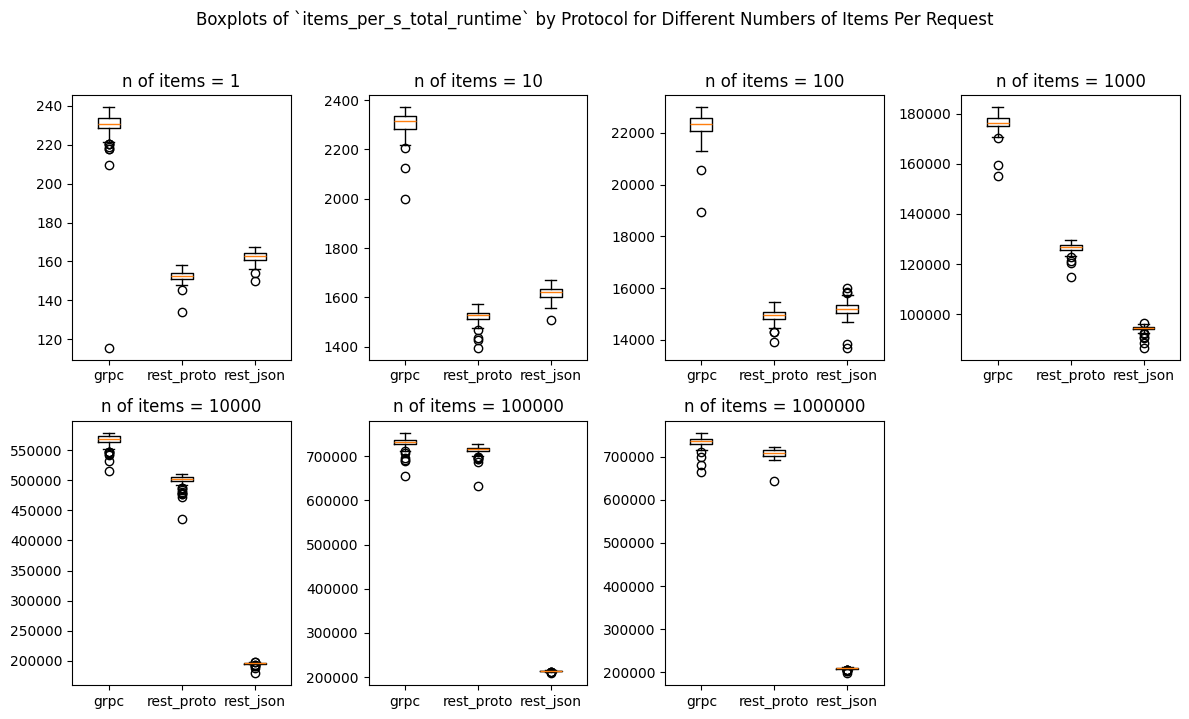

In [23]:
boxplots_by_size(df_latency, protocols=['grpc', 'rest_proto', 'rest_json'], col='items_per_s_total_runtime')

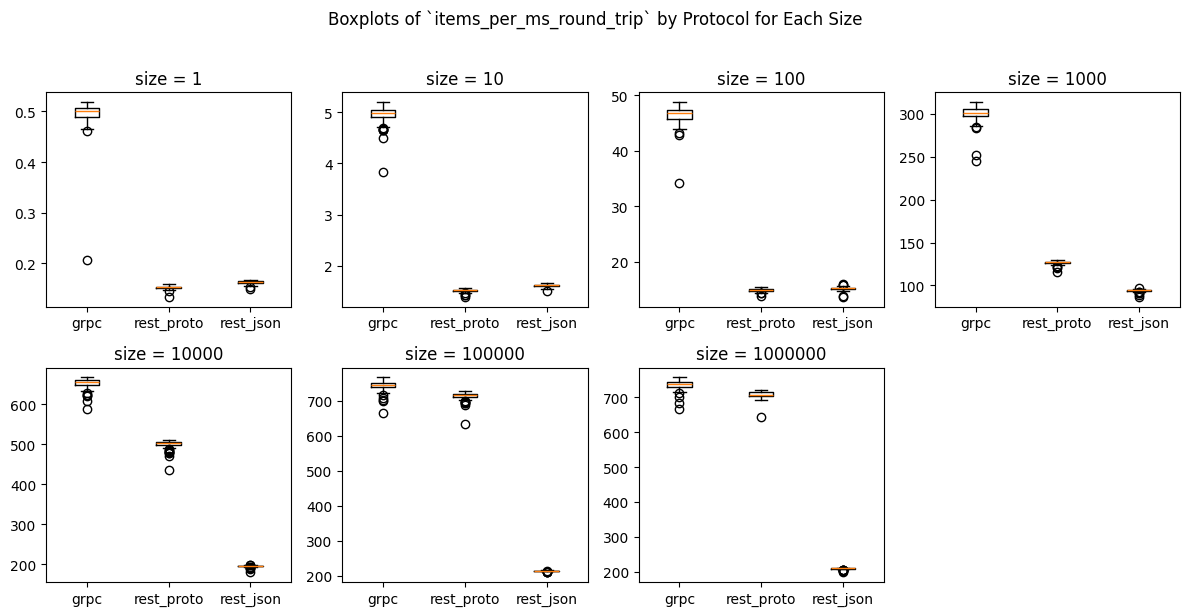

In [40]:
boxplots_by_size(df_latency, protocols=['grpc', 'rest_proto', 'rest_json'], col='items_per_ms_round_trip')